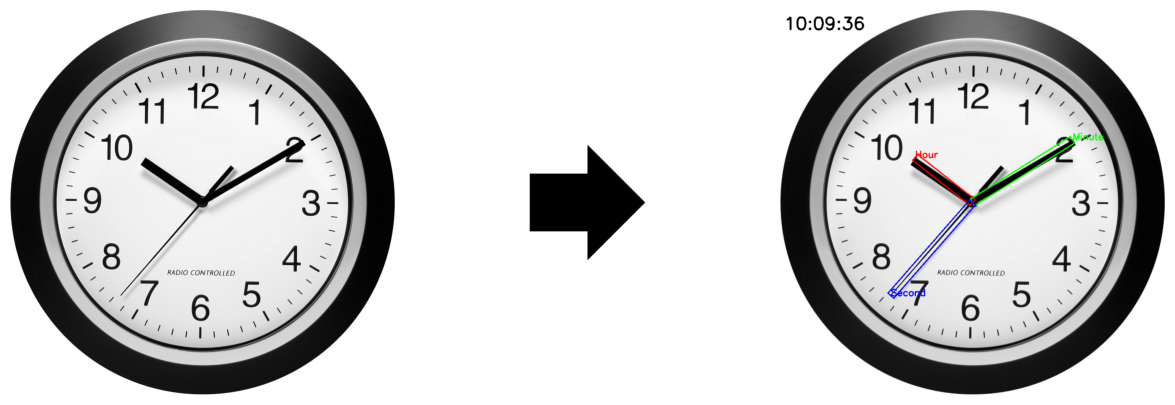

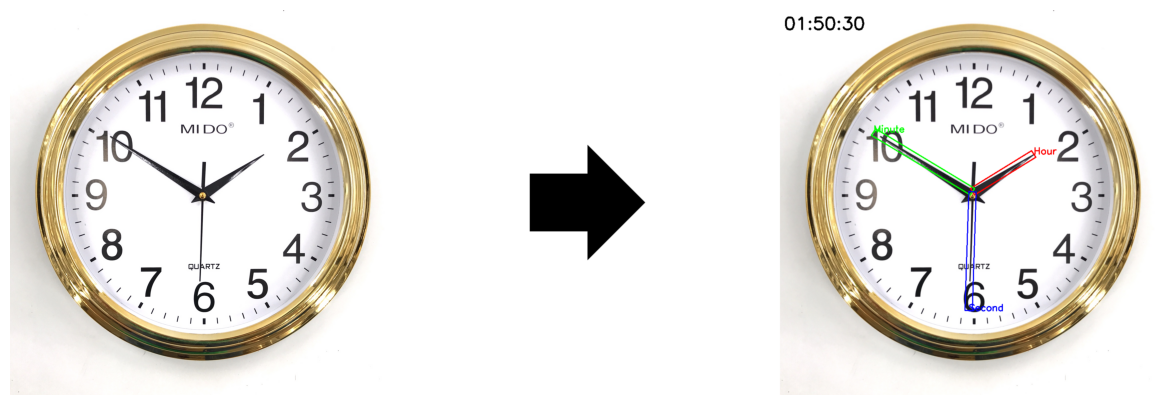

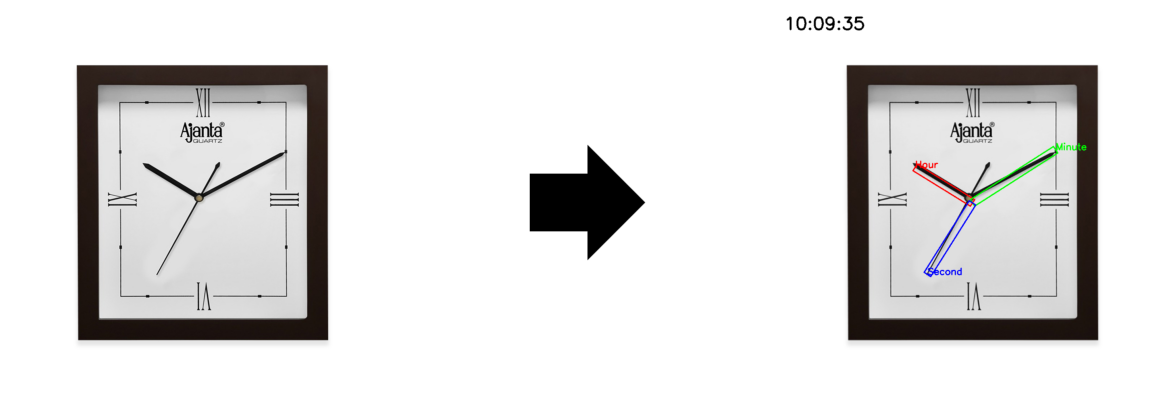

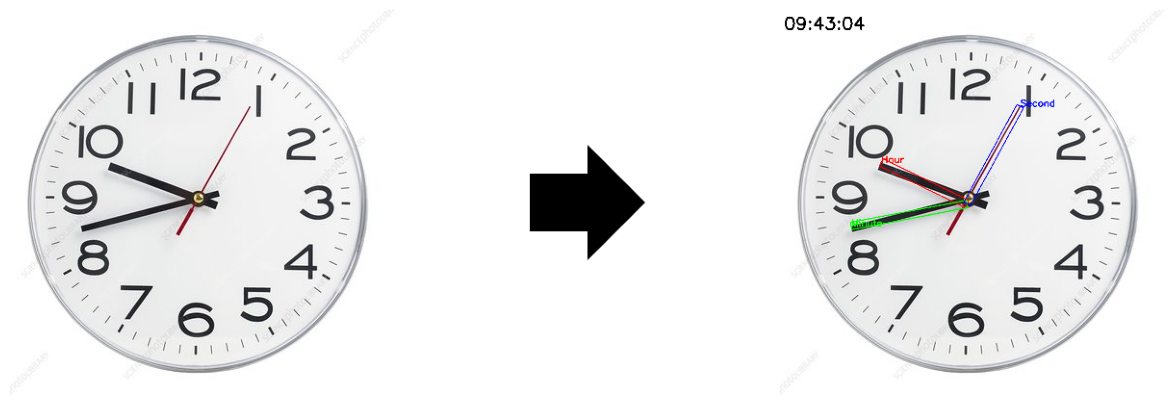

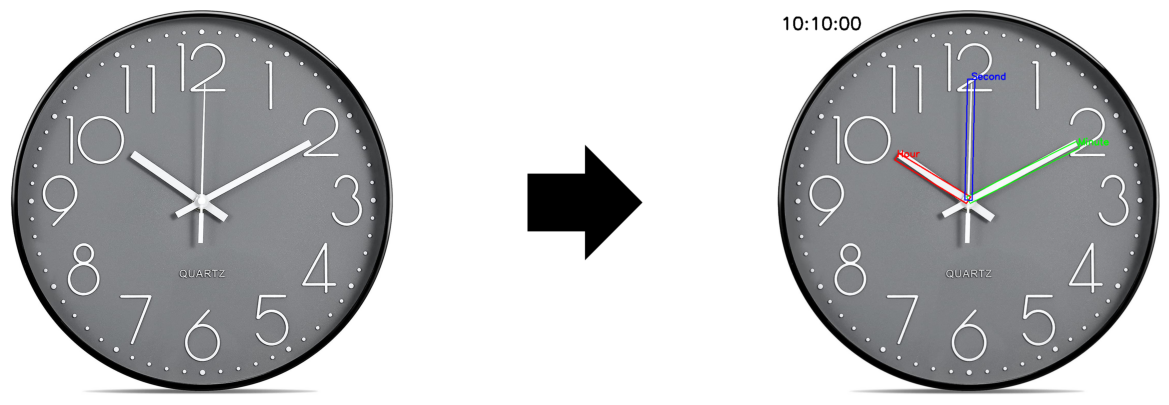

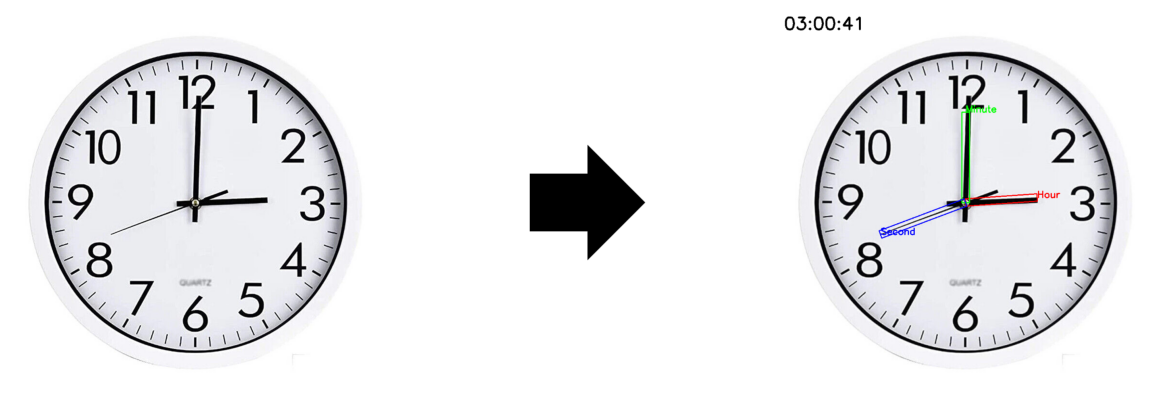

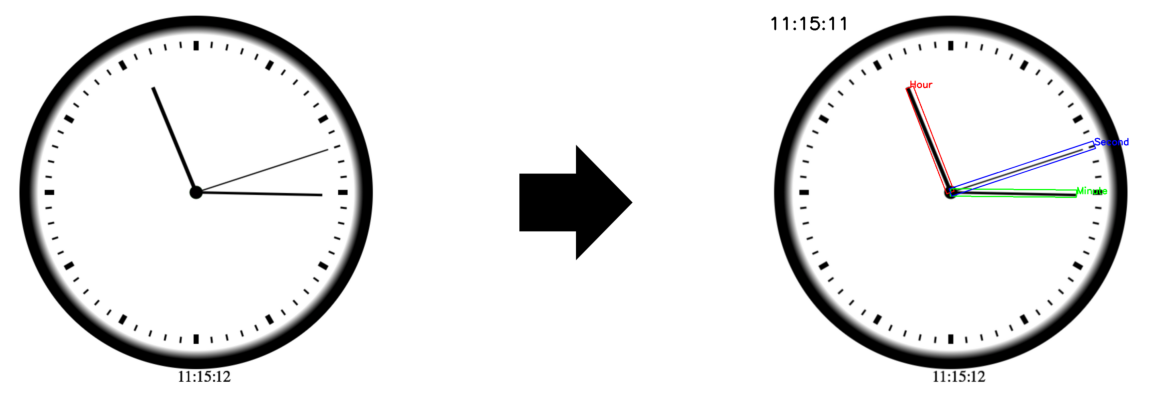

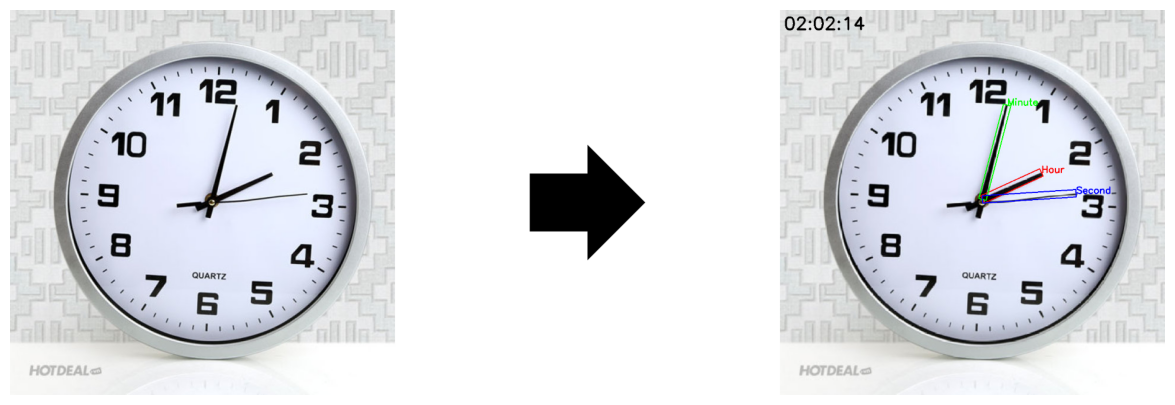

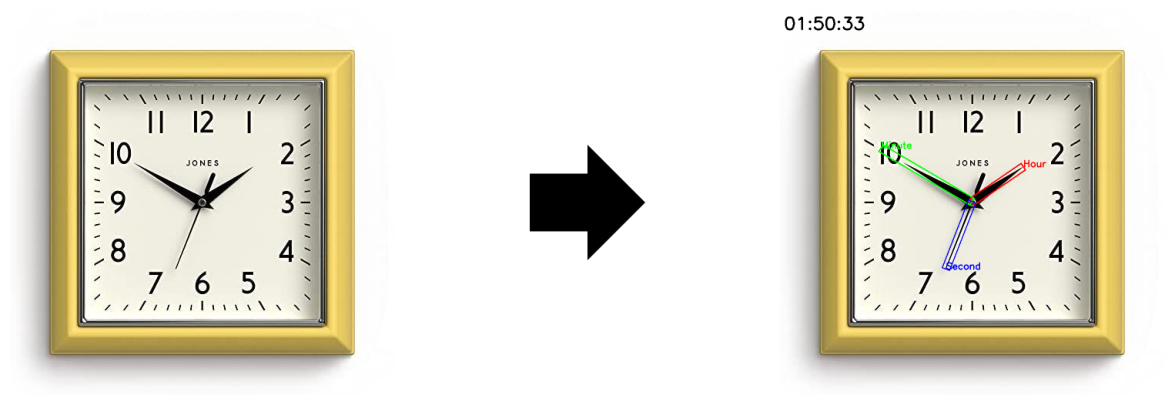

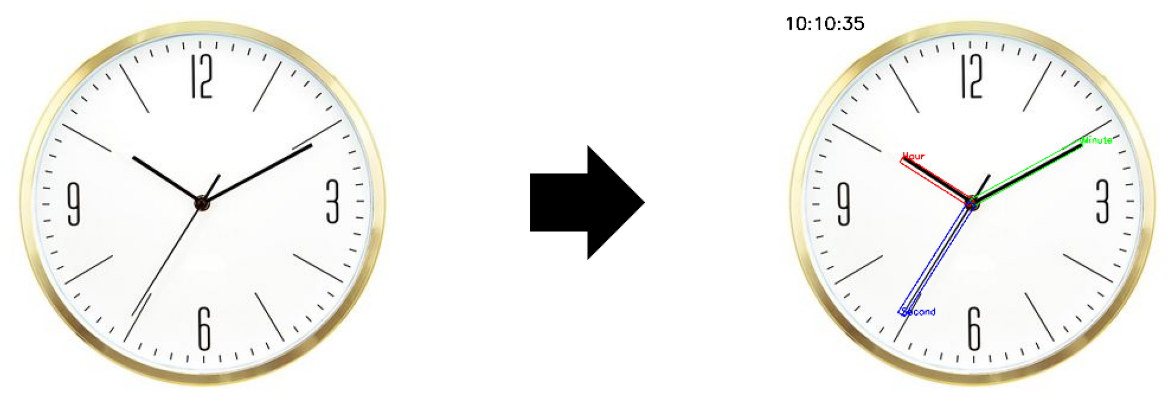

In [1]:
import cv2
import numpy as np
import math
import os
import matplotlib.pyplot as plt


def show_image(image, title="Image"):
    plt.figure(figsize=(7, 7))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(title)
    plt.show()


def resize_image(image, max_size=1000):
    height, width = image.shape[:2]
    scale = max_size / max(height, width)
    new_size = (int(width * scale), int(height * scale))
    return cv2.resize(image, new_size, interpolation=cv2.INTER_AREA)


def find_circle(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray, 5)

    x_center, y_center, radius = None, None, None

    circles = cv2.HoughCircles(
        gray,
        cv2.HOUGH_GRADIENT,
        1,
        120,
        param1=100,
        param2=100,
        minRadius=40,
        maxRadius=0,
    )

    if circles is not None:
        x_center, y_center, radius = np.uint16(np.around(circles[0, 0]))

    else:
        edges = cv2.Canny(gray, 50, 150)
        contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        for contour in sorted(contours, key=cv2.contourArea, reverse=True):
            perimeter = cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)
            if len(approx) == 4:
                x, y, w, h = cv2.boundingRect(approx)
                x_center = x + w // 2
                y_center = y + h // 2
                radius = max(w, h) // 2
                break

    return x_center, y_center, radius


def detect_and_group_lines(blurred, center_x, center_y, radius):
    edges = cv2.Canny(blurred, 50, 150)
    lines = cv2.HoughLinesP(
        edges, 1, np.pi / 180, threshold=100, minLineLength=100, maxLineGap=20
    )

    if lines is None:
        return []

    groups = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        lengths = [
            np.linalg.norm([x1 - center_x, y1 - center_y]),
            np.linalg.norm([x2 - center_x, y2 - center_y]),
        ]
        if max(lengths) < radius and min(lengths) < 0.4 * radius:
            angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
            for group in groups:
                mean_angle = group["mean_angle"]
                if any(abs(angle - mean_angle - d) < 12 for d in (0, 180, -180)):
                    group["lines"].append(line)
                    break
            else:
                groups.append({"lines": [line], "mean_angle": angle})
    return groups


def parallel_line_distance(line1, line2):
    x1, y1, x2, y2 = line1[0]
    u = np.array([x2 - x1, y2 - y1])
    v = np.array([line2[0][2] - line2[0][0], line2[0][3] - line2[0][1]])
    w = np.array([line2[0][0] - x1, line2[0][1] - y1])
    return np.abs(np.cross(u, w)) / np.linalg.norm(u)


def detect_hands(groups, center_x, center_y):
    hands = []
    for group in groups:
        max_length, max_thickness, max_line = 0, 0, None
        for line in group["lines"]:
            x1, y1, x2, y2 = line[0]
            lengths = [
                np.linalg.norm([x1 - center_x, y1 - center_y]),
                np.linalg.norm([x2 - center_x, y2 - center_y]),
            ]
            length = max(lengths)
            if length > max_length:
                max_length = length
                max_line = (
                    [x1, y1, center_x, center_y]
                    if length == lengths[0]
                    else [x2, y2, center_x, center_y]
                )
            for other_line in group["lines"]:
                thickness = parallel_line_distance(line, other_line)
                if thickness > max_thickness:
                    max_thickness = thickness
        if max_thickness > 0:
            hands.append((max_line, max_thickness, max_length))
    hands.sort(key=lambda x: x[2], reverse=True)
    return hands[:3]


def classify_hands(hands):
    if len(hands) < 3:
        return None, None, None
    hands.sort(key=lambda x: x[1])
    second_hand = hands[0]
    remaining_hands = sorted(hands[1:], key=lambda x: x[2])
    return remaining_hands[0], remaining_hands[1], second_hand


def calculate_hand_angle(hand):
    x1, y1, x2, y2 = hand[0]
    dx = x2 - x1
    dy = y1 - y2

    vector_length = math.sqrt(dx**2 + dy**2)
    dot_product = dy * -1
    cos_theta = max(-1.0, min(1.0, dot_product / vector_length))
    angle = math.degrees(math.acos(cos_theta))

    if dx >= 0:
        angle = 360 - angle

    return angle


def convert_angles_to_time(hour_angle, minutes_angle, second_angle):
    if minutes_angle < 90:
        hour_angle += 3

    hours = "00"
    minutes = "00"
    seconds = "00"

    if 0 <= hour_angle < 30 or (0 <= hour_angle < 35 and minutes_angle > 350):
        hours = "12"
    elif 30 <= hour_angle < 60 or (30 <= hour_angle < 65 and minutes_angle > 350):
        hours = "01"
    elif 60 <= hour_angle < 90 or (60 <= hour_angle < 95 and minutes_angle > 350):
        hours = "02"
    elif 90 <= hour_angle < 120 or (90 <= hour_angle < 125 and minutes_angle > 350):
        hours = "03"
    elif 120 <= hour_angle < 150 or (120 <= hour_angle < 155 and minutes_angle > 350):
        hours = "04"
    elif 150 <= hour_angle < 180 or (150 <= hour_angle < 185 and minutes_angle > 350):
        hours = "05"
    elif 180 <= hour_angle < 210 or (180 <= hour_angle < 215 and minutes_angle > 350):
        hours = "06"
    elif 210 <= hour_angle < 240 or (210 <= hour_angle < 245 and minutes_angle > 350):
        hours = "07"
    elif 240 <= hour_angle < 270 or (240 <= hour_angle < 275 and minutes_angle > 350):
        hours = "08"
    elif 270 <= hour_angle < 300 or (270 <= hour_angle < 305 and minutes_angle > 350):
        hours = "09"
    elif 300 <= hour_angle < 330 or (300 <= hour_angle < 335 and minutes_angle > 350):
        hours = "10"
    elif 330 <= hour_angle < 360 or (
        (330 <= hour_angle < 360 or 0 <= hour_angle < 5) and minutes_angle > 350
    ):
        hours = "11"
    else:
        "Error"

    minutes = round(minutes_angle / 360 * 60, 2)
    minutes_int = int(minutes)
    minutes_str = str(minutes_int)
    if minutes_int < 10:
        minutes_str = "0" + minutes_str

    if minutes_int == 60:
        if (int(hours) + 1) < 10:
            hours = "0" + str(int(hours) + 1)
        else:
            hours = str(int(hours) + 1)
        minutes_str = "00"
    time = hours + ":" + minutes_str

    seconds = int(second_angle / 6)
    seconds_str = str(seconds)
    if seconds < 10:
        seconds_str = "0" + str(seconds)
    time = time + ":" + seconds_str

    return time


def draw_time(image, time):
    cv2.putText(image, time, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 0), 3)


def draw_hand_contour(image, hand, color, label):
    x1, y1, x2, y2 = hand[0]
    thickness = 10
    angle = math.atan2(y2 - y1, x2 - x1)
    dx = thickness * math.sin(angle)
    dy = thickness * math.cos(angle)
    contour = np.array(
        [
            [x1 - dx, y1 + dy],
            [x1 + dx, y1 - dy],
            [x2 + dx, y2 - dy],
            [x2 - dx, y2 + dy],
        ],
        np.int32,
    ).reshape((-1, 1, 2))
    cv2.polylines(image, [contour], isClosed=True, color=color, thickness=2)
    cv2.putText(image, label, (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)


def process_image(image_path, index):
    image = cv2.imread(image_path)
    if image is None:
        print("Không thể đọc ảnh.")
        return
    image = resize_image(image)
    blurred_image = cv2.GaussianBlur(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), (5, 5), 0)

    center_x, center_y, radius = find_circle(image)
    if center_x is None:
        print("Không thể phát hiện đồng hồ.")
        return
    gray = cv2.cvtColor(blurred_image, cv2.COLOR_GRAY2BGR)
    groups = detect_and_group_lines(blurred_image, center_x, center_y, radius)

    hour_hand, minute_hand, second_hand = classify_hands(
        detect_hands(groups, center_x, center_y)
    )

    if hour_hand is None or minute_hand is None or second_hand is None:
        print("Không thể phát hiện đủ các kim đồng hồ.")
        return

    for hand, color, label in zip(
        [hour_hand, minute_hand, second_hand],
        [(0, 0, 255), (0, 255, 0), (255, 0, 0)],
        ["Hour", "Minute", "Second"],
    ):
        draw_hand_contour(image, hand, color, label)

    time = convert_angles_to_time(
        calculate_hand_angle(hour_hand),
        calculate_hand_angle(minute_hand),
        calculate_hand_angle(second_hand),
    )
    draw_time(image, time)

    return image
    # show_image(image, f"Image {index + 1} - {time}")


def main():
    dir_path = "images"
    for index, file_name in enumerate(os.listdir(dir_path)):
        image_path = os.path.join(dir_path, file_name)

        processed_image = process_image(image_path, index)
        original_image = cv2.imread(image_path)
        processed_image = cv2.resize(
            processed_image, (original_image.shape[1], original_image.shape[0])
        )

        mui_ten = cv2.imread("mui_ten.png")
        mui_ten = cv2.resize(
            mui_ten, (original_image.shape[1], original_image.shape[0])
        )

        combined_image = np.hstack([original_image, mui_ten, processed_image])
        plt.figure(figsize=(15, 5))
        plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()


if __name__ == "__main__":
    main()